In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.io import fits
from astropy.utils import data
from spectral_cube import SpectralCube
from astropy.wcs import WCS
from reproject import reproject_interp

In [ ]:
data = fits.open('/home/patito/Documents/datoselectivo/cubo/jellifysh.fits')
cubo = SpectralCube.read(data[1])
data.close()

In [ ]:
print(cubo)

SpectralCube with shape=(3682, 330, 328) and unit=1e-20 erg / (Angstrom s cm2):
 n_x:    328  type_x: RA---TAN  unit_x: deg    range:   354.092428 deg:  354.111908 deg
 n_y:    330  type_y: DEC--TAN  unit_y: deg    range:    21.141321 deg:   21.159599 deg
 n_s:   3682  type_s: AWAV      unit_s: Angstrom  range:     4750.401 Angstrom:    9351.651 Angstrom


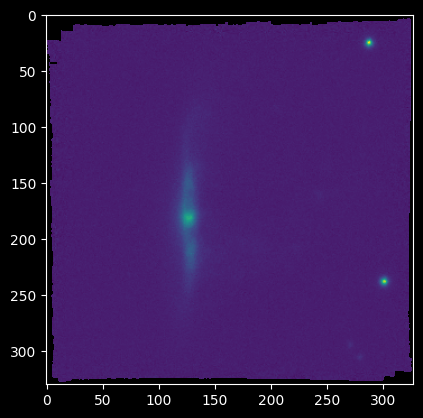

In [ ]:
%matplotlib inline
cubo[320,:,:].quicklook()

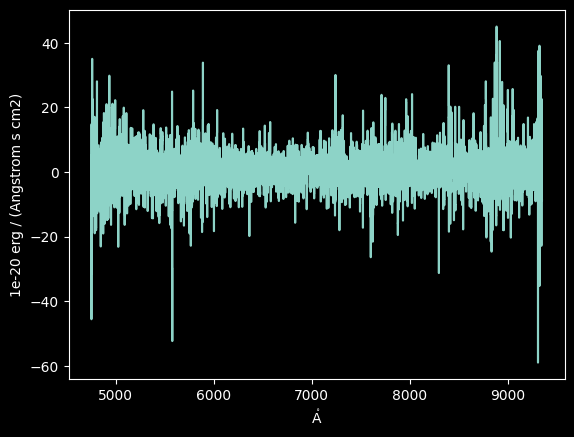

In [ ]:
%matplotlib inline
cubo[:, 150, 225].quicklook() #extract a single spectrum through the data cube

In [ ]:
#latitud y longitud de la imagen, se ponen las unidades en astropy
lat_range = [21.141321,21.159599] * u.deg 
lon_range = [354.092428,354.111908] * u.deg
#se genera el cubo con la informacion de ra dec
cubo = cubo.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1], zlo=6920*u.AA, zhi=7050*u.AA)

In [ ]:
cubo.moment(order=1)

/home/patito/.local/lib/python3.10/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


<Projection [[          nan,           nan,           nan, ...,
                        nan,           nan,           nan],
             [          nan,           nan,           nan, ...,
              6912.27198622,           nan,           nan],
             [          nan,           nan,           nan, ...,
              6951.23632105,           nan,           nan],
             ...,
             [          nan,           nan,           nan, ...,
                        nan,           nan,           nan],
             [          nan,           nan,           nan, ...,
                        nan,           nan,           nan],
             [          nan,           nan,           nan, ...,
                        nan,           nan,           nan]] Angstrom>

In [ ]:
stellarcontinuum.unit

Unit("1e-20 erg / (s cm2)")

In [ ]:
moment_0_stellarcontinuum = cubo.with_spectral_unit(u.AA).moment(order=0)  # Zero-th moment 
moment_1_halpha = cubo.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=6563*u.AA).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('ha_moment_0.fits') 
# moment_1.write('ha_moment_1.fits')

# Convert Moment_0 to a Column Density assuming optically thin media
#stellarcontinuum = moment_0_stellarcontinuum * 10**20 * (u.cm * u.cm) * u.s / u.erg
stellarcontinuum = moment_0_stellarcontinuum

/home/patito/.local/lib/python3.10/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in divide
  return (np.nansum(data * pix_cen, axis=axis) /


In [ ]:
lista = []
for i in range(len(stellarcontinuum.hdu.data)):
    a = stellarcontinuum.hdu.data[i]
    for j in range(len(stellarcontinuum.hdu.data[i])):
        b = stellarcontinuum.hdu.data[i][j]
        if b != 'nan':
            aux = stellarcontinuum.hdu.data[i][j]
            lista.append(aux)
        else:
            continue

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

In [ ]:
stellarcontinuum.hdu.data

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ..., -107.234146,
                nan,         nan],
       [        nan,         nan,         nan, ..., -244.37024 ,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

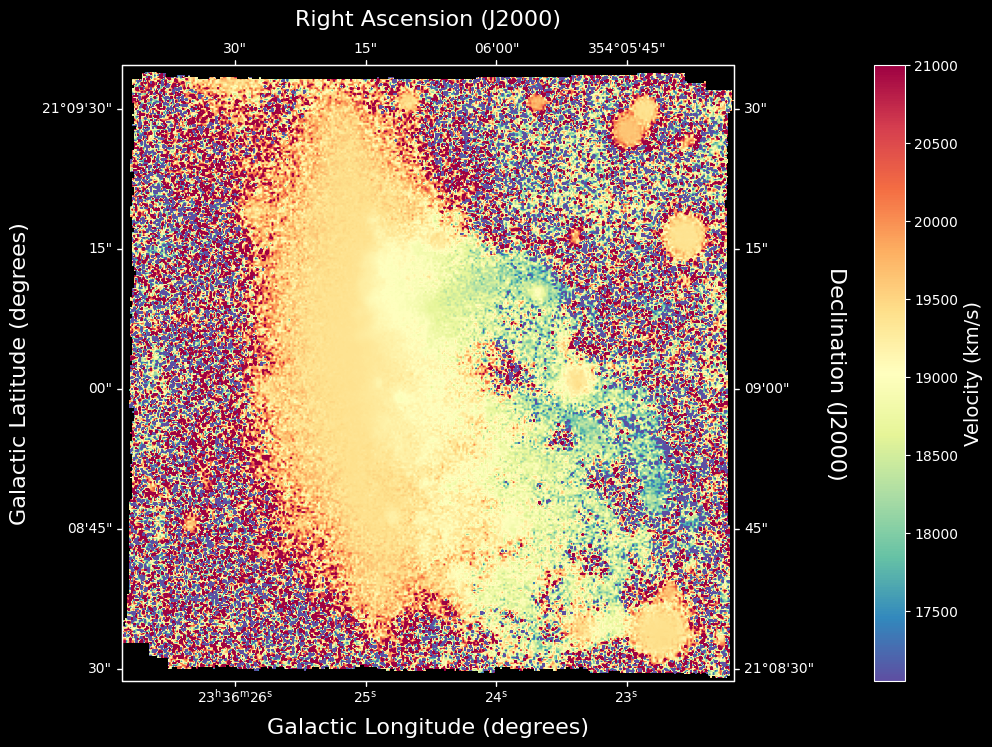

In [ ]:
%matplotlib inline
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(12, 8),facecolor='black')
plt.style.use('dark_background')
ax = fig.add_subplot(111, projection=moment_1_halpha.wcs)

# Display the moment map image
im = ax.imshow(moment_1_halpha.hdu.data, cmap='Spectral_r', vmin=17050, vmax=21000)
#ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)


# Add a colorbar
cbar = plt.colorbar(im, pad=.15)
cbar.set_label('Velocity (km/s)', size=14)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
#overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours   # Define contour levels to use
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(stellarcontinuum.hdu.data, cmap='magma', alpha=0.8, levels=levels)

TypeError: 'numpy.dtypes.Float32DType' object is not callable